In [0]:
import os 
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from matplotlib import pyplot as plt
import json
from PIL import Image
from IPython.display import Image as disp_image
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns


In [0]:
model_parameters = dict()
model_parameters['image_height'] = 256
model_parameters['image_width'] = 256
model_parameters['batch_size'] = 8
model_parameters['channels'] = 3
model_parameters['epochs'] = 20

In [0]:
train_datagen = ImageDataGenerator(rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  rescale=1/255.,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  fill_mode = 'nearest',
                                  validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1/255.)
training_set = train_datagen.flow_from_directory(
    'drive/My Drive/Диплом/Статьи/dataset/training',
    target_size=(model_parameters['image_height'],model_parameters['image_width']),
    batch_size = model_parameters['batch_size'],
    class_mode='binary',
    subset='training',
    shuffle=True)
validation_set = train_datagen.flow_from_directory(
    'drive/My Drive/Диплом/Статьи/dataset/training',
    target_size=(model_parameters['image_height'],model_parameters['image_width']),
    batch_size = model_parameters['batch_size'],
    class_mode='binary',
    subset='validation',
    shuffle=False)
test_set = test_datagen.flow_from_directory(
    'drive/My Drive/Диплом/Статьи/dataset/test',
    target_size = (model_parameters['image_height'],model_parameters['image_width']),
    batch_size = 1,
    shuffle = False,
    class_mode = 'binary')

print(training_set.class_indices)

Found 108 images belonging to 2 classes.
Found 25 images belonging to 2 classes.
Found 18 images belonging to 2 classes.
{'covid': 0, 'healthy': 1}


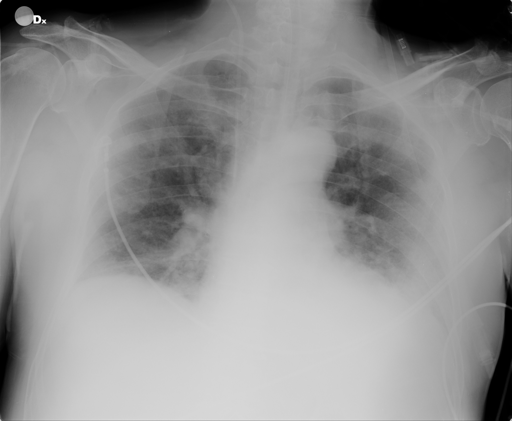

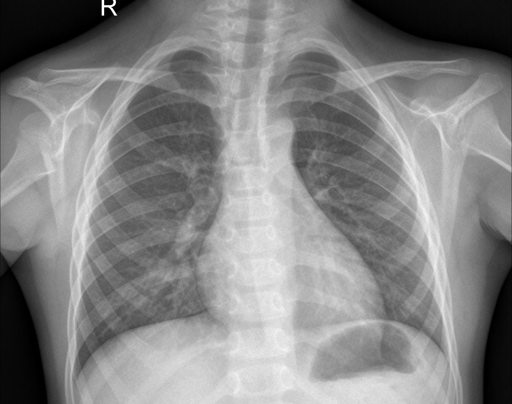

In [0]:
covid_files = os.listdir(os.path.join('drive','My Drive','Диплом','Статьи','dataset','training','covid'))
health_files = os.listdir(os.path.join('drive','My Drive','Диплом','Статьи','dataset','training','healthy'))
covid_indx = np.random.randint(0,len(covid_files))
healthy_indx = np.random.randint(0,len(health_files))

covid_image = Image.open(os.path.join('drive','My Drive','Диплом','Статьи','dataset','training','covid',covid_files[covid_indx]))
healthy_image = Image.open(os.path.join('drive','My Drive','Диплом','Статьи','dataset','training','healthy',health_files[healthy_indx]))
covid_image.thumbnail((512,512))
healthy_image.thumbnail((512,512))
display(covid_image)
display(healthy_image)

In [0]:
main_model_res = ResNet50(weights='imagenet',include_top = False,input_shape = (model_parameters['image_width'],model_parameters['image_height'],model_parameters['channels']))
for layer in main_model_res.layers[:-5]:
    layer.trainable = False
model_res = Sequential()
model_res.add(main_model_res)
model_res.add(Flatten())
model_res.add(Dense(256, activation='relu'))
model_res.add(Dropout(0.5))
model_res.add(Dense(1, activation='sigmoid'))

print(main_model_res.summary())
print(model_res.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
model_res.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4,decay = 1e-6),
             metrics = ['accuracy'])
history_resnet = model_res.fit_generator(
                training_set,
                steps_per_epoch = training_set.n // model_parameters['batch_size'],
                epochs = 20,
                validation_data=validation_set,
                validation_steps=validation_set.n //model_parameters['batch_size']
)


Epoch 1/20
13/13 [==============================] - 6s 431ms/step - loss: 0.6033 - accuracy: 0.8200 - val_loss: 0.2225 - val_accuracy: 0.8750
Epoch 2/20
13/13 [==============================] - 5s 403ms/step - loss: 0.6061 - accuracy: 0.8100 - val_loss: 0.1229 - val_accuracy: 0.9583
Epoch 3/20
13/13 [==============================] - 5s 384ms/step - loss: 0.4065 - accuracy: 0.8700 - val_loss: 0.4139 - val_accuracy: 0.7500
Epoch 4/20
13/13 [==============================] - 5s 391ms/step - loss: 0.5424 - accuracy: 0.7800 - val_loss: 0.2933 - val_accuracy: 0.8750
Epoch 5/20
13/13 [==============================] - 5s 386ms/step - loss: 0.5819 - accuracy: 0.7981 - val_loss: 0.2094 - val_accuracy: 0.8750
Epoch 6/20
13/13 [==============================] - 5s 395ms/step - loss: 0.3911 - accuracy: 0.8600 - val_loss: 0.3879 - val_accuracy: 0.8333
Epoch 7/20
13/13 [==============================] - 5s 397ms/step - loss: 0.5034 - accuracy: 0.7500 - val_loss: 0.2841 - val_accuracy: 0.7917
Epoch 

In [0]:
main_model_vgg = VGG16(weights='imagenet',include_top = False,input_shape = (model_parameters['image_width'],model_parameters['image_height'],model_parameters['channels']))
for layer in main_model_vgg.layers[:-5]:
    layer.trainable = False
model_vgg = Sequential()
model_vgg.add(main_model_vgg)
model_vgg.add(Flatten())
model_vgg.add(Dense(256, activation='relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(1, activation='sigmoid'))

print(main_model_vgg.summary())
print(model_vgg.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [0]:
model_vgg.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4,decay = 1e-6),
             metrics = ['accuracy'])
history_vgg = model_vgg.fit_generator(
                training_set,
                steps_per_epoch = training_set.n // model_parameters['batch_size'],
                epochs = 20,
                validation_data=validation_set,
                validation_steps=validation_set.n //model_parameters['batch_size']
)

Epoch 1/20
13/13 [==============================] - 5s 414ms/step - loss: 0.7862 - accuracy: 0.6200 - val_loss: 0.4562 - val_accuracy: 0.7917
Epoch 2/20
13/13 [==============================] - 5s 358ms/step - loss: 0.5173 - accuracy: 0.7700 - val_loss: 0.2583 - val_accuracy: 0.9167
Epoch 3/20
13/13 [==============================] - 6s 425ms/step - loss: 0.4093 - accuracy: 0.8000 - val_loss: 0.3206 - val_accuracy: 0.8750
Epoch 4/20
13/13 [==============================] - 5s 383ms/step - loss: 0.4377 - accuracy: 0.8100 - val_loss: 0.1258 - val_accuracy: 1.0000
Epoch 5/20
13/13 [==============================] - 5s 415ms/step - loss: 0.2230 - accuracy: 0.9100 - val_loss: 0.2180 - val_accuracy: 0.9167
Epoch 6/20
13/13 [==============================] - 5s 383ms/step - loss: 0.1731 - accuracy: 0.9000 - val_loss: 0.5816 - val_accuracy: 0.7500
Epoch 7/20
13/13 [==============================] - 5s 410ms/step - loss: 0.1373 - accuracy: 0.9500 - val_loss: 0.1842 - val_accuracy: 0.9167
Epoch 

In [0]:
#model_res.save('covid_res.h5',save_format='h5')
#model_vgg.save('covid_vgg.h5',save_format='h5')

In [0]:
acc_res = history_resnet.history['accuracy']
acc_vgg = history_vgg.history['accuracy']
val_acc_res = history_resnet.history['val_accuracy']
val_acc_vgg = history_vgg.history['val_accuracy']
loss_res = history_resnet.history['loss']
loss_vgg = history_vgg.history['loss']
val_loss_res = history_resnet.history['val_loss']
val_loss_vgg = history_vgg.history['val_loss']

## Посмотрим как протекало обучение для модели с остаточным обучением - ResNet

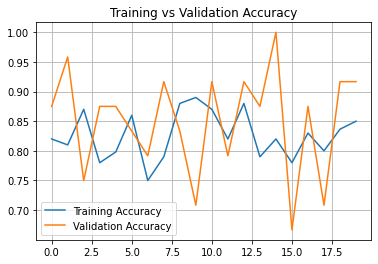

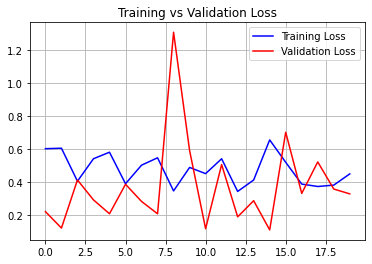

In [0]:
epochs = range(len(acc_res))
plt.plot(epochs,acc_res,label = 'Training Accuracy')
plt.plot(epochs,val_acc_res,label = 'Validation Accuracy')
plt.grid()
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss_res,'b',label='Training Loss')
plt.plot(epochs,val_loss_res,'r',label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.grid()
plt.legend()
plt.show()

## Посмотрим как протекало обучение для модели VGG

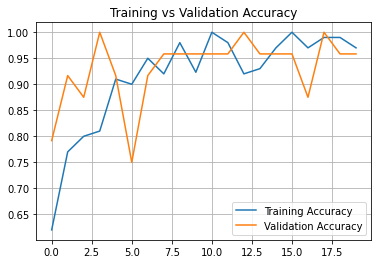

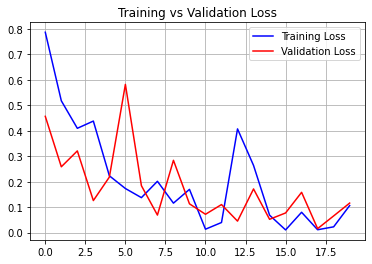

In [0]:
epochs = range(len(acc_res))
plt.plot(epochs,acc_vgg,label = 'Training Accuracy')
plt.plot(epochs,val_acc_vgg,label = 'Validation Accuracy')
plt.grid()
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss_vgg,'b',label='Training Loss')
plt.plot(epochs,val_loss_vgg,'r',label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.grid()
plt.legend()
plt.show()

## Сравним эти модели между собой

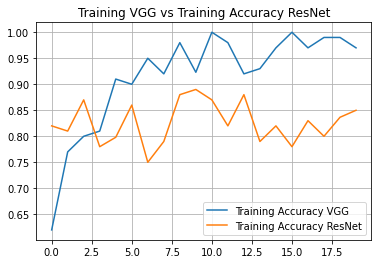

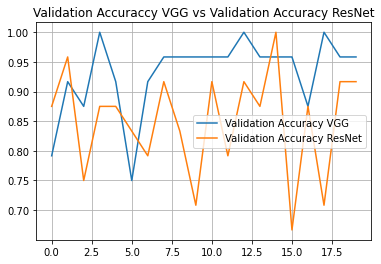

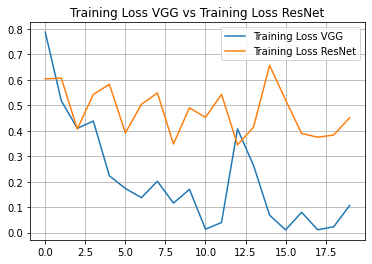

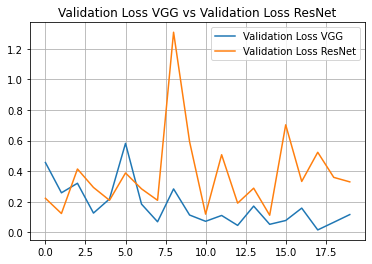

In [0]:
epochs = range(len(acc_res))
plt.plot(epochs,acc_vgg,label = 'Training Accuracy VGG')
plt.plot(epochs,acc_res,label = 'Training Accuracy ResNet')
plt.grid()
plt.title('Training VGG vs Training Accuracy ResNet')
plt.legend()
plt.figure()
plt.plot(epochs,val_acc_vgg,label = 'Validation Accuracy VGG')
plt.plot(epochs,val_acc_res,label = 'Validation Accuracy ResNet')
plt.grid()
plt.title('Validation Accuraccy VGG vs Validation Accuracy ResNet')
plt.legend()
plt.figure()
plt.plot(epochs,loss_vgg,label='Training Loss VGG')
plt.plot(epochs,loss_res,label='Training Loss ResNet')
plt.title('Training Loss VGG vs Training Loss ResNet')
plt.grid()
plt.legend()
plt.show()
plt.figure()
plt.plot(epochs,val_loss_vgg,label='Validation Loss VGG')
plt.plot(epochs,val_loss_res,label='Validation Loss ResNet')
plt.title('Validation Loss VGG vs Validation Loss ResNet')
plt.grid()
plt.legend()
plt.show()

In [0]:
model_res.load_weights('covid_res.h5')
model_vgg.load_weights('covid_vgg.h5')
test_pred_res = model_res.evaluate(test_set,steps=test_set.n//model_parameters['batch_size'],verbose=1)
test_pred_vgg = model_vgg.evaluate(test_set,steps=test_set.n//model_parameters['batch_size'],verbose=1)
print('Test accuracy ResNet: ', test_pred_res[1])
print('Test accuracy VGG: ', test_pred_vgg[1])

2/2 [==============================] - 0s 14ms/step - loss: 4.3569e-07 - accuracy: 1.0000
Test accuracy ResNet:  1.0
Test accuracy VGG:  1.0


18/18 [==============================] - 1s 30ms/step


[Text(0, 0.5, 'COVID-19'), Text(0, 1.5, 'Healthy')]

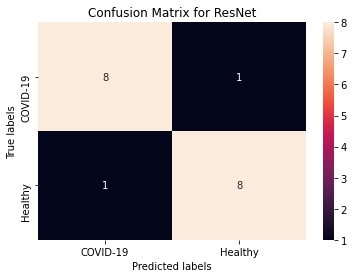

In [0]:
test_pred_res = model_res.predict(test_set,steps = test_set.n, use_multiprocessing=False,verbose= 1)
test_pred_vgg = model_vgg.predict(test_set,steps=test_set.n, use_multiprocessing=False,verbose = 1)
test_pred_class_res = (test_pred_res >= 0.5)
test_pred_class_vgg = (test_pred_vgg >= 0.5)

cm_res = confusion_matrix(test_set.classes,test_pred_class_res)
cm_vgg = confusion_matrix(test_set.classes,test_pred_class_vgg)
ax_res = plt.subplot()
sns.heatmap(cm_res,ax = ax_res,annot=True)
ax_res.set_xlabel('Predicted labels')
ax_res.set_ylabel('True labels')
ax_res.set_title('Confusion Matrix for ResNet') 
ax_res.xaxis.set_ticklabels(['COVID-19', 'Healthy'])
ax_res.yaxis.set_ticklabels(['COVID-19', 'Healthy']) 

[Text(0, 0.5, 'COVID-19'), Text(0, 1.5, 'Healthy')]

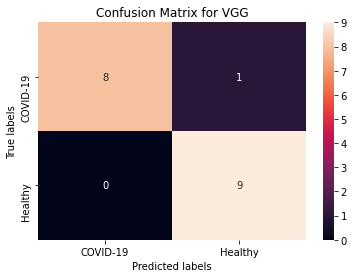

In [0]:
ax_vgg = plt.subplot()
sns.heatmap(cm_vgg,ax = ax_vgg,annot=True)
ax_vgg.set_xlabel('Predicted labels')
ax_vgg.set_ylabel('True labels')
ax_vgg.set_title('Confusion Matrix for VGG') 
ax_vgg.xaxis.set_ticklabels(['COVID-19', 'Healthy'])
ax_vgg.yaxis.set_ticklabels(['COVID-19', 'Healthy']) 

In [0]:
print(classification_report(test_set.classes,
                     test_pred_class_res))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.89      0.89      0.89         9

    accuracy                           0.89        18
   macro avg       0.89      0.89      0.89        18
weighted avg       0.89      0.89      0.89        18



In [0]:
print(classification_report(test_set.classes,
                     test_pred_class_vgg))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.90      1.00      0.95         9

    accuracy                           0.94        18
   macro avg       0.95      0.94      0.94        18
weighted avg       0.95      0.94      0.94        18

